In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dragonn.models import Model, SequenceDNN
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.layers.core import (
    Activation, Dense, Dropout, Flatten,
    Permute, Reshape, TimeDistributedDense
)
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.recurrent import GRU
from keras.regularizers import l1

from deeplift import keras_conversion as kc
from deeplift.blobs import MxtsMode

Using Theano backend.
Using gpu device 1: GeForce GTX TITAN X (CNMeM is enabled with initial size: 2500 MB, cuDNN 5004)
/users/jisraeli/local/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [122]:
class LongRangeDNN(SequenceDNN):
    def __init__(self, num_features=11, num_nodes=2, use_deep_CNN=False,
                  num_tasks=1, num_filters=25,
                  num_filters_2=25, num_filters_3=25,
                  L1=0, dropout=0.0, verbose=2):
        self.num_features = num_features
        self.num_nodes = num_nodes
        self.input_shape = (1, num_features, num_nodes)
        self.num_tasks = num_tasks
        self.verbose = verbose
        self.model = Sequential()
        self.model.add(Convolution2D(
            nb_filter=num_filters, nb_row=num_features,
            nb_col=1, activation='linear',
            init='he_normal', input_shape=self.input_shape))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(dropout))
        if use_deep_CNN:
            self.model.add(Convolution2D(
                nb_filter=num_filters_2, nb_row=1,
                nb_col=1, activation='relu',
                init='he_normal', W_regularizer=l1(L1)))
            self.model.add(Dropout(dropout))
            self.model.add(Convolution2D(
                nb_filter=num_filters_3, nb_row=1,
                nb_col=1, activation='relu',
                init='he_normal', W_regularizer=l1(L1)))
            self.model.add(Dropout(dropout))
        self.model.add(Flatten())
        self.model.add(Dense(output_dim=25, activation='relu'))
        self.model.add(Dense(output_dim=25, activation='relu'))
        self.model.add(Dense(output_dim=25, activation='relu'))
        self.model.add(Dense(output_dim=self.num_tasks))
        self.model.add(Activation('sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy')
        self.train_losses = None
        self.valid_losses = None
    
    def train(self, X, y, validation_data):
        if y.dtype != bool:
            assert len(np.unique(y)) == 2
            y = y.astype(bool)
        multitask = y.shape[1] > 1
        if not multitask:
            num_positives = y.sum()
            num_sequences = len(y)
            num_negatives = num_sequences - num_positives
        self.callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
        if self.verbose >= 1:
            self.callbacks.append(self.PrintMetrics(validation_data, self))
            print('Training model...')
        self.callbacks.append(self.LossHistory(X, y, validation_data, self))
        self.model.fit(
            X, y, batch_size=250, nb_epoch=100,
            validation_data=validation_data,
            class_weight={True: num_sequences / num_positives,
                          False: num_sequences / num_negatives}
            if not multitask else None,
            callbacks=self.callbacks, verbose=self.verbose >= 2)
        self.train_losses = self.callbacks[-1].train_losses
        self.valid_losses = self.callbacks[-1].valid_losses
        
    def deeplift(self, X, batch_size=200):
        """
        Returns (num_task, num_samples, input_shape) deeplift score array.
        """
        # run deeplift
        deeplift_model = kc.convert_sequential_model(
            self.model, mxts_mode=MxtsMode.DeepLIFT)
        target_contribs_func = deeplift_model.get_target_contribs_func(
            find_scores_layer_idx=0)
        return np.asarray([
            target_contribs_func(task_idx=i, input_data_list=[X],
                                 batch_size=batch_size, progress_update=10000)
            for i in range(self.num_tasks)])


def get_features(X_path):
    # load data
    X = np.load(X_path)
    # reshape data
    _, num_features, num_nodes = X.shape
    return X.reshape(len(X), 1, num_features, num_nodes)

    
def get_labels(y_path):
    # load data
    y = np.load(y_path)
    # reshape data
    return y.reshape((len(y)), 1).astype(bool)

def subsample_data(X, y, imbalance_ratio=10):
    neg_indxs = np.where(y==False)[0]
    pos_indxs = np.where(y==True)[0]
    num_negatives = len(pos_indxs)*imbalance_ratio
    y_subsampled = np.array([y[i] for i in np.concatenate((pos_indxs, neg_indxs[:num_negatives]))])
    X_subsampled = np.array([X[i] for i in np.concatenate((pos_indxs, neg_indxs[:num_negatives]))])
    
    return (X_subsampled, y_subsampled)

def normalize_features(X_train, X_valid, X_test, normalizer=MinMaxScaler):
    # fit normalizer
    normalizer = normalizer().fit(X_train[:, 0, :, 0])
    # transform features
    X_train[:, 0, :, 0] = normalizer.transform(X_train[:, 0, :, 0])
    X_train[:, 0, :, 1] = normalizer.transform(X_train[:, 0, :, 1])
    X_valid[:, 0, :, 0] = normalizer.transform(X_valid[:, 0, :, 0])
    X_valid[:, 0, :, 1] = normalizer.transform(X_valid[:, 0, :, 1])
    X_test[:, 0, :, 0] = normalizer.transform(X_test[:, 0, :, 0])
    X_test[:, 0, :, 1] = normalizer.transform(X_test[:, 0, :, 1])
    
    return (X_train, X_valid, X_test) 

In [94]:
X_train = get_features('NN_all_data/train_set_upperTriangle_noDiag_reads.npy')
y_train = get_labels('NN_all_data/labels_train_upperTriangle_noDiag.npy')
X_valid = get_features('NN_all_data/vali_set_upperTriangle_noDiag_reads.npy')
y_valid = get_labels('NN_all_data/labels_vali_upperTriangle_noDiag.npy')
X_test = get_features('NN_all_data/test_set_upperTriangle_noDiag_reads.npy')
y_test = get_labels('NN_all_data/labels_test_upperTriangle_noDiag.npy')
"""
X_train = get_features('NN_datasets/train_set_all_reads.npy')
y_train = get_labels('NN_datasets/labels_train_all.npy')
X_valid = get_features('NN_datasets/vali_set_all_reads.npy')
y_valid = get_labels('NN_datasets/labels_vali_all.npy')
X_test = get_features('NN_datasets/test_set_all_reads.npy')
y_test = get_labels('NN_datasets/labels_test_all.npy')
"""
X_train_subsampled, y_train_subsampled = subsample_data(X_train, y_train)
X_valid_subsampled, y_valid_subsampled = subsample_data(X_valid, y_valid)
X_test_subsampled, y_test_subsampled = subsample_data(X_test, y_test)

In [74]:
X_train_scaled, X_valid_scaled, X_test_scaled = normalize_features(X_train, X_valid, X_test)
X_train_normalized, X_valid_normalized, X_test_normalized = normalize_features(X_train, X_valid, X_test,
                                                                               normalizer=StandardScaler)

In [75]:
X_train_normalized_subsampled, y_train_subsampled = subsample_data(X_train_normalized, y_train)
X_valid_normalized_subsampled, y_valid_subsampled = subsample_data(X_valid_normalized, y_valid)
X_test_normalized_subsampled, y_test_subsampled = subsample_data(X_test_normalized, y_test)

X_train_scaled_subsampled, y_train_subsampled = subsample_data(X_train_scaled, y_train)
X_valid_scaled_subsampled, y_valid_subsampled = subsample_data(X_valid_scaled, y_valid)
X_test_scaled_subsampled, y_test_subsampled = subsample_data(X_test_scaled, y_test)

In [123]:
dnn_normalized = LongRangeDNN(num_features=10, use_deep_CNN=True)

In [127]:
validation_data = (X_valid_subsampled[:, :, :10, :], y_valid_subsampled)
#validation_data = (X_test_normalized_subsampled[:, :, :10, :], y_test_subsampled)
#validation_data = (X_test_subsampled[:, :, :10, :], y_test_subsampled)

dnn_normalized.train(X_train_subsampled[:, :, :10, :], y_train_subsampled, validation_data)
#dnn_normalized.train(X_test_normalized_subsampled[:, :, :10, :], y_test_subsampled, validation_data)
#dnn_normalized.train(X_test_subsampled[:, :, :10, :], y_test_subsampled, validation_data)

Training model...
Train on 121011 samples, validate on 74063 samples
Epoch 1/100
121011/121011 [==============================] - 1s - loss: 1.1073 - val_loss: 0.6387
Epoch 0: validation loss: 0.639
Balanced Accuracy: 65.53%	 auROC: 0.720	 auPRC: 0.214	 auPRG: 0.687
Recall at 5%|10%|20% FDR: 0.1%|0.1%|1.0%	 Num Positives: 6733	 Num Negatives: 67330	 

Epoch 2/100
121011/121011 [==============================] - 0s - loss: 1.1034 - val_loss: 0.6187
Epoch 1: validation loss: 0.619
Balanced Accuracy: 66.24%	 auROC: 0.724	 auPRC: 0.216	 auPRG: 0.698
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.8%	 Num Positives: 6733	 Num Negatives: 67330	 

Epoch 3/100
121011/121011 [==============================] - 0s - loss: 1.1007 - val_loss: 0.6382
Epoch 2: validation loss: 0.638
Balanced Accuracy: 65.95%	 auROC: 0.724	 auPRC: 0.216	 auPRG: 0.702
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.6%	 Num Positives: 6733	 Num Negatives: 67330	 

Epoch 4/100
121011/121011 [==============================] - 0s - loss: 1.09

In [128]:
print(dnn_normalized.test(X_test[:, :, :10, :], y_test))

Balanced Accuracy: 66.48%	 auROC: 0.735	 auPRC: 0.030	 auPRG: 0.932
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 4467	 Num Negatives: 511505	 


In [ ]:
pred_probs = dnn_normalized.predict(X_test_normalized[:, :, :10, :])
np.save("model_predictions/test_set_upperTriangle_noDiag_reads_without_distances.npy", pred_probs)

In [113]:
print(dnn_normalized.test(X_valid[:, :, :10, :], y_valid))

Balanced Accuracy: 64.36%	 auROC: 0.696	 auPRC: 0.021	 auPRG: 0.855
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6733	 Num Negatives: 767223	 


In [105]:
print(dnn_normalized.test(X_train[:, :, :10, :], y_train))

Balanced Accuracy: 64.16%	 auROC: 0.696	 auPRC: 0.018	 auPRG: 0.809
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 11001	 Num Negatives: 1278927	 


In [51]:
dnn_normalized.train(X_train_normalized[:, :, :10, :], y_train,
                     (X_valid_normalized[:, :, :10, :], y_valid))

Training model...
Train on 1289928 samples, validate on 773956 samples
Epoch 1/100
 548750/1289928 [===========>..................] - ETA: 4s - loss: 1.1940

KeyboardInterrupt: 

In [52]:
reads_normalized_full_result = dnn_normalized.test(X_valid_normalized[:, :, :10, :], y_valid)
print("reads_normalized_full_result...")
print(reads_normalized_full_result)

reads_normalized_full_result...
Balanced Accuracy: 65.52%	 auROC: 0.718	 auPRC: 0.022	 auPRG: 0.840
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6733	 Num Negatives: 767223	 


In [54]:
reads_normalized_full_test_result = dnn_normalized.test(X_test_normalized[:, :, :10, :], y_test)
print("reads_normalized_full_test_result...")
print(reads_normalized_full_test_result)

reads_normalized_full_test_result...
Balanced Accuracy: 50.87%	 auROC: 0.510	 auPRC: 0.222	 auPRG: -0.013
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 4467	 Num Negatives: 511505	 


In [56]:
pred_probs = dnn_normalized.predict(X_test_normalized[:, :, :10, :])
np.save("model_predictions/test_set_upperTriangle_noDiag_reads_without_distances.npy", pred_probs)

In [12]:
dnn_scaled = LongRangeDNN(num_features=10, use_deep_CNN=True)

In [15]:
reads_scaled_validation_data = (X_valid_scaled_subsampled[:, :, :10, :], y_valid_subsampled)
dnn_scaled.train(X_train_scaled_subsampled[:, :, :10, :], y_train_subsampled, reads_scaled_validation_data)

Training model...
Train on 256685 samples, validate on 153131 samples
Epoch 1/100
256685/256685 [==============================] - 3s - loss: 1.1474 - val_loss: 0.5901
Epoch 0: validation loss: 0.590
Balanced Accuracy: 67.81%	 auROC: 0.751	 auPRC: 0.236	 auPRG: 0.749
Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.3%	 Num Positives: 13921	 Num Negatives: 139210	 

Epoch 2/100
256685/256685 [==============================] - 3s - loss: 1.1404 - val_loss: 0.5817
Epoch 1: validation loss: 0.582
Balanced Accuracy: 68.00%	 auROC: 0.753	 auPRC: 0.241	 auPRG: 0.753
Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.4%	 Num Positives: 13921	 Num Negatives: 139210	 

Epoch 3/100
256685/256685 [==============================] - 3s - loss: 1.1364 - val_loss: 0.5742
Epoch 2: validation loss: 0.574
Balanced Accuracy: 67.64%	 auROC: 0.749	 auPRC: 0.239	 auPRG: 0.752
Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.4%	 Num Positives: 13921	 Num Negatives: 139210	 

Epoch 4/100
256685/256685 [==============================] - 3s - los

In [43]:
X_train_scaled, X_test_scaled = normalize_features(X_train, X_test)

In [44]:
reads_scaled_full_test_result = dnn_scaled.test(X_test_scaled[:, :, :10, :], y_test)
print("reads_scaled_full_test_result...")
print(reads_scaled_full_test_result)

reads_scaled_full_test_result...
Balanced Accuracy: 55.85%	 auROC: 0.562	 auPRC: 0.119	 auPRG: -0.127
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 9418	 Num Negatives: 1022979	 


In [77]:
X_train_normalized_2, X_valid_normalized_2 = normalize_features(X_train, X_valid, normalizer=StandardScaler)

In [78]:
X_train_subsampled_2, y_train_subsampled_2 = subsample_data(X_train_normalized_2, y_train)
X_valid_subsampled_2, y_valid_subsampled_2 = subsample_data(X_valid_normalized_2, y_valid)

In [88]:
dnn_normalized_2 = LongRangeDNN(num_features=10, use_deep_CNN=True)

In [89]:
validation_data = (X_valid_subsampled_2[:, :, :10, :], y_valid_subsampled_2)
dnn_normalized_2.train(X_train_subsampled_2[:, :, :10, :], y_train_subsampled_2, validation_data)

Training model...
Train on 153428 samples, validate on 153428 samples
Epoch 1/100
153428/153428 [==============================] - 2s - loss: 1.3800 - val_loss: 0.6948
Epoch 0: validation loss: 0.695
Balanced Accuracy: 56.34%	 auROC: 0.587	 auPRC: 0.126	 auPRG: 0.408
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 13948	 Num Negatives: 139480	 

Epoch 2/100
153428/153428 [==============================] - 2s - loss: 1.3605 - val_loss: 0.6620
Epoch 1: validation loss: 0.662
Balanced Accuracy: 58.22%	 auROC: 0.610	 auPRC: 0.139	 auPRG: 0.480
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 13948	 Num Negatives: 139480	 

Epoch 3/100
153428/153428 [==============================] - 2s - loss: 1.3474 - val_loss: 0.6812
Epoch 2: validation loss: 0.681
Balanced Accuracy: 58.77%	 auROC: 0.621	 auPRC: 0.145	 auPRG: 0.513
Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 13948	 Num Negatives: 139480	 

Epoch 4/100
153428/153428 [==============================] - 2s - los

In [94]:
preds = dnn_normalized_2.predict(X_valid_subsampled_2[:, :, :10, :])

In [100]:
(preds>0.75).sum()

5339

In [102]:
pos_indxs = y_valid_subsampled_2==True
pred_pos_indxs = preds > 0.5
true_pos_indxs = pos_indxs*pred_pos_indxs

In [103]:
true_pos_indxs

array([[False],
       [ True],
       [False],
       ..., 
       [False],
       [False],
       [False]], dtype=bool)

In [105]:
dl_scores = dnn_normalized_2.deeplift(X_valid_subsampled_2[true_pos_indxs[:,0], :, :10, :])

Done 0


In [106]:
dl_scores.shape

(1, 9293, 1, 10, 2)

In [107]:
_, num_examples, _, num_features, num_nodes = dl_scores.shape
concat_dl_scores = dl_scores[0, :, 0, :, :].reshape(num_examples, num_features*num_nodes)

In [114]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [115]:
pca = PCA(n_components=2)

In [116]:
fit_pca = pca.fit(concat_dl_scores)

In [117]:
concat_dl_scores_reduced = pca.transform(concat_dl_scores)

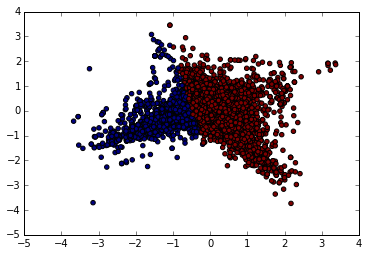

In [131]:
from matplotlib import pyplot as plt
plt.scatter(concat_dl_scores_reduced[:, 0], concat_dl_scores_reduced[:, 1], c=clusters2)
plt.show()

In [122]:
from sklearn.cluster import KMeans

In [129]:
kmeans = KMeans(n_clusters=2).fit(concat_dl_scores)

In [130]:
clusters2 = kmeans.predict(concat_dl_scores)

In [132]:
tsne = TSNE(verbose=1)

In [133]:
fit_tsne = tsne.fit(concat_dl_scores)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 9293
[t-SNE] Computed conditional probabilities for sample 2000 / 9293
[t-SNE] Computed conditional probabilities for sample 3000 / 9293
[t-SNE] Computed conditional probabilities for sample 4000 / 9293
[t-SNE] Computed conditional probabilities for sample 5000 / 9293
[t-SNE] Computed conditional probabilities for sample 6000 / 9293
[t-SNE] Computed conditional probabilities for sample 7000 / 9293
[t-SNE] Computed conditional probabilities for sample 8000 / 9293
[t-SNE] Computed conditional probabilities for sample 9000 / 9293
[t-SNE] Computed conditional probabilities for sample 9293 / 9293
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 1.207627
[t-SNE] Error after 350 iterations: 1.161084


In [135]:
concat_dl_scores_tsne = fit_tsne.fit_transform(concat_dl_scores)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 9293
[t-SNE] Computed conditional probabilities for sample 2000 / 9293
[t-SNE] Computed conditional probabilities for sample 3000 / 9293
[t-SNE] Computed conditional probabilities for sample 4000 / 9293
[t-SNE] Computed conditional probabilities for sample 5000 / 9293
[t-SNE] Computed conditional probabilities for sample 6000 / 9293
[t-SNE] Computed conditional probabilities for sample 7000 / 9293
[t-SNE] Computed conditional probabilities for sample 8000 / 9293
[t-SNE] Computed conditional probabilities for sample 9000 / 9293
[t-SNE] Computed conditional probabilities for sample 9293 / 9293
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 1.206784
[t-SNE] Error after 425 iterations: 1.160552


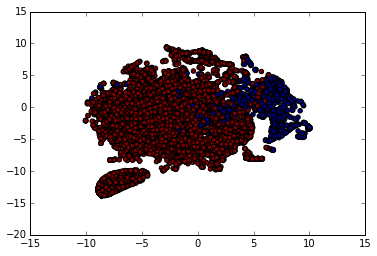

In [136]:
plt.scatter(concat_dl_scores_tsne[:, 0], concat_dl_scores_tsne[:, 1], c=clusters2)
plt.show()